In [20]:
import pandas as pd
from dateutil import parser
import numpy as np
import csv
from sklearn.neighbors import KNeighborsRegressor
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import math
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import LabelEncoder

In [21]:
# Import data
data = pd.read_csv("TaxiTrip2021Subset.csv")
data["Payment Type"] = LabelEncoder().fit_transform(data["Payment Type"])
data["Company"] = LabelEncoder().fit_transform(data["Company"])

# List to hold trip start hour
time = []
# Iterate through dataframe rows
for index, row in data.iterrows():
    # Retrieve the hour of start time and add it to list
    time.append(parser.parse(row['Trip Start Timestamp']).time().hour)

# Add start hour column to dataframe
data['Start Hour'] = time

# Split set into 80 training/20 test
train = data.sample(frac=0.8)
test = data.drop(train.index).sample(frac=1.0)

# Drop Tips and other non important columns
train_X = train.drop(columns=['Tips', 'Trip Start Timestamp', 'Trip End Timestamp'])
# Tips only column
train_Y = train['Tips']

fs = SelectKBest(score_func=mutual_info_regression, k='all')
fs.fit(train_X, train_Y)
fs_dict = {}

for i in range(len(fs.scores_)):
    # If not an Nan value
    if not (math.isnan(fs.scores_[i])): 
        # Add to dictionary 
        fs_dict[train_X.columns[i]] = fs.scores_[i]
# Sort dictionary by values
fs_dict = dict(sorted(fs_dict.items(), key=lambda item: item[1]))

# Convert dictionary to list
fs_list = list(fs_dict.keys())
# Variables to hold 
first = fs_list[-1]
second = fs_list[-2]
third = fs_list[-3]
fourth = fs_list[-4]

In [22]:
# Include only these top 4 columns found by the K Best
train_X = train[[first, second, third, fourth]]
train_Y = train['Tips']

test_X = test[[first, second, third, fourth]]
test_Y = test['Tips']

In [23]:
# Create KNN model and find RMSE
KNN = KNeighborsRegressor()
KNN.fit(train_X, train_Y)
pred_Y = KNN.predict(test_X)
error = math.sqrt(mean_squared_error(test_Y,pred_Y))
print("RMSE with Default Parameters: " + "{:.2f}".format(error))
    
# Save Model
pickle.dump(KNN, open('KNN_Default_Model.sav', 'wb'))

RMSE with Default Parameters: 1.07


In [24]:
display(pd.DataFrame({"Y Tips": test_Y, "Predicted": np.round(pred_Y,2)}))
pd.options.display.min_rows = 25

,Y Tips,Predicted
2760,0.00,0.00
6645,5.00,4.60
5270,0.00,0.00
8831,0.00,0.00
7478,0.00,0.00
3352,0.00,0.00
500,1.00,1.13
2208,0.00,0.00
2697,4.00,3.20
8631,0.00,0.00


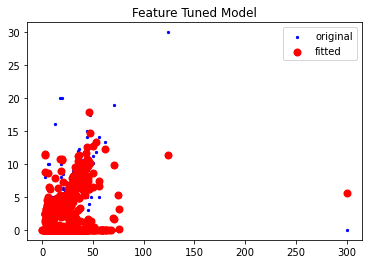

In [25]:
plt.scatter(test_X['Fare'], test_Y, s=5, color="blue", label="original")
plt.scatter(test_X['Fare'], pred_Y, lw=2, color="red", label="fitted")
plt.title('Feature Tuned Model')
plt.legend()
plt.show()

In [26]:
parameters = {'n_neighbors':[1,2,3,4,5,6,7,8,9,10],
                'weights':['uniform', 'distance'],
                'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],}
gs_clf = GridSearchCV(KNN, param_grid=parameters, scoring = 'r2', cv=5)
gs_clf.fit(train_X, train_Y)

for param_name in gs_clf.best_params_:
    print("{0}:\t{1}".format(param_name,gs_clf.best_params_[param_name]))

# Store best parameters into list
best_params_list = list(gs_clf.best_params_.values())

algorithm = best_params_list[0]
n_neighbors = best_params_list[1]
weights = best_params_list[2]

KNN_Optimized = KNeighborsRegressor(algorithm=algorithm, n_neighbors=n_neighbors, weights=weights)
KNN_Optimized.fit(train_X, train_Y)

pred_Y = KNN_Optimized.predict(test_X)
error = math.sqrt(mean_squared_error(test_Y,pred_Y))
print("RMSE with Optimized Parameters: " + "{:.2f}".format(error))

# Save Model
pickle.dump(KNN_Optimized, open('KNN_Optimized_Model.sav', 'wb'))

algorithm:	ball_tree
n_neighbors:	7
weights:	distance
RMSE with Optimized Parameters: 0.98


In [27]:
display(pd.DataFrame({"Y Tips": test_Y, "Predicted": np.round(pred_Y,2)}))

,Y Tips,Predicted
2760,0.00,0.00
6645,5.00,4.54
5270,0.00,0.00
8831,0.00,0.00
7478,0.00,0.00
3352,0.00,0.00
500,1.00,1.08
2208,0.00,0.00
2697,4.00,3.32
8631,0.00,0.00


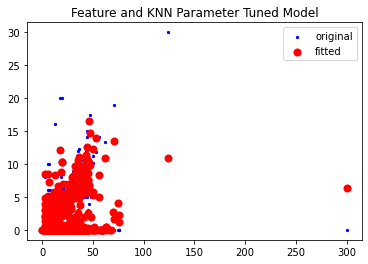

In [28]:
plt.scatter(test_X['Fare'], test_Y, s=5, color="blue", label="original")
plt.scatter(test_X['Fare'], pred_Y, lw=2, color="red", label="fitted")
plt.title('Feature and KNN Parameter Tuned Model')
plt.legend()
plt.show()